In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
%matplotlib inline

import skimage.io

show = skimage.io.imshow

In [2]:
"""
Main script for FCNT tracker. 
"""
#%%
# Import custom class and functions
from inputproducer import InputProducer
from tracker import TrackerVanilla
from vgg16 import Vgg16
from selcnn import SelCNN
from sgnet import GNet, SNet
from utils import img_with_bbox, IOU_eval

import numpy as np 
import tensorflow as tf
import matplotlib.pylab as plt

import os
import time
#%%
tf.app.flags.DEFINE_integer('iter_step_sel', 600,
                          """Number of steps for trainning"""
                          """selCNN networks.""")
tf.app.flags.DEFINE_integer('iter_step_sg', 50,
                          """Number of steps for trainning"""
                          """SGnet works""")
tf.app.flags.DEFINE_integer('num_sel', 512,
                          """Number of feature maps selected.""")
tf.app.flags.DEFINE_integer('iter_max', 200,
							"""Max iter times through imgs""")

FLAGS = tf.app.flags.FLAGS

## Define varies path
DATA_ROOT = 'data/Dog1'
PRE_ROOT = os.path.join(DATA_ROOT, 'img_loc')
IMG_PATH = os.path.join(DATA_ROOT, 'img')
GT_PATH = os.path.join(DATA_ROOT, 'groundtruth_rect.txt')
VGG_WEIGHTS_PATH = 'vgg16_weights.npz'
#%%



def train_sgNet(sess, gnet, snet, sgt_M, ggt_M, feed_dict):
	"""
	Train sgnet by minimize the loss
	Loss = Lg + Ls
	where Li = |pre_Mi - gt_M|**2 + Weights_decay_term_i

	"""
	# Initialize sgNet variables
	sgNet_vars = gnet.variables + snet.variables
	init_SGNet_vars_op = tf.initialize_variables(sgNet_vars, name='init_sgNet')
	sess.run(init_SGNet_vars_op)

	# Define composite loss
	total_losses = snet.loss(sgt_M) + gnet.loss(ggt_M)

	# Define trainning op
	optimizer = tf.train.GradientDescentOptimizer(1e-6)
	train_op = optimizer.minimize(total_losses, var_list= sgNet_vars)

	for step in range(FLAGS.iter_step_sg):
		loss, _ = sess.run([total_losses, train_op], feed_dict = feed_dict)
		print("SGNet Loss: ", loss)



def gen_mask_phi(img_sz, loc):
	x,y,w,h = loc
	phi = np.zeros(img_sz)
	phi[y-int(0.5*h): y+int(0.5*h), x-int(0.5*w):x+int(0.5*w)] = 1
	return phi
#%%


In [3]:


import tensorflow as tf
import numpy as np

from utils import variable_on_cpu, variable_with_weight_decay

def non2zero(l):
	return [0 if i==None else i for i in l] 

class SelCNN:
	def __init__(self, scope, vgg_conv_layer, gt_M_sz):
		"""
		selCNN network class. Initialize graph.

		Args: 
			name: string, name of the network.
			vgg_conv_layer: tensor, either conv4_3 or cnv5_3 layer
				of a pretrained vgg16 network
		"""
		# Initialize network
		self.scope = scope
		self.input_layer = vgg_conv_layer

		# Unpack vgg_conv_layer for partial derivatives
		self.feature_maps = [vgg_conv_layer[...,i] for i in range(512)]
		self.variables = []
		self.params = {
		'dropout_rate': 0.3,
		'k_size': [3, 3, 512, 1],
		'wd': 0.0,
		'lr_initial': 1e-6, # 1e-8 gives 438 after 200 steps, 1e-7 gives better maps?
		'lr_decay_steps': 500,
		'lr_decay_rate':  0.5
		}
		with tf.name_scope(scope) as scope:
			self.pre_M = self._get_pre_M()
			self.gt_M = tf.placeholder(tf.float32, shape=gt_M_sz)
		self.pre_M_size = self.pre_M.get_shape().as_list()[1:3]
		


	def _get_pre_M(self):
		"""Build the sel-CNN graph and returns predicted Heat map."""
		input_maps = tf.pack(self.feature_maps, axis=-1)
		dropout_layer = tf.nn.dropout(input_maps, self.params['dropout_rate'])

		# Conv layer with bias 
		kernel = variable_with_weight_decay(self.scope, 'kernel',\
							self.params['k_size'], wd = self.params['wd'])
		conv = tf.nn.conv2d(dropout_layer, kernel, [1,1,1,1], 'SAME')
		bias = variable_on_cpu(self.scope,'biases', [1], tf.constant_initializer(0.1))
		pre_M = tf.nn.bias_add(conv, bias)
		self.variables += [kernel, bias]
		# Subtract mean 
		pre_M -= tf.reduce_mean(pre_M)
		#pre_M# /= tf.reduce_max(pre_M)
		return pre_M


	def train_op(self, global_step, add_regulizer=False):
		""" Train the network on the fist frame. 

		Args:
			gt_M_sz: tuple, shape identical to self.pre_M,
				Ground truth heatmap.
			add_regulizer: bool, True for adding L2 regulizer of the 
				kernel variables of the conv layer.

		Returns:
			train_op:
			total_losses:
			lr:
		"""
		pre_shape = self.pre_M.get_shape().as_list()[1:]
		gt_shape = self.gt_M.get_shape().as_list()[1:]
		assert gt_shape == pre_shape, 'Shapes are not compatiable! gt_M : {0}, pre_M : {1}'.format(gt_shape, pre_shape)
		
		#with tf.variable_scope(self.scope) as scope:
		# Root mean square loss
		rms_loss = tf.reduce_mean(tf.squared_difference(self.gt_M, self.pre_M))
		# tf.squared_difference(x, y, name=None) try this! 
		# (x-y)(x-y) 

		tf.add_to_collection('losses', rms_loss)

		# Use vanila SGD with exponentially decayed learning rate
		# Decayed_learning_rate = learning_rate *
		#                decay_rate ^ (global_step / decay_steps)
		lr = tf.train.exponential_decay(
			self.params['lr_initial'], 
			global_step, 
			self.params['lr_decay_steps'], 
			self.params['lr_decay_rate'] , 
			name='lr')

		# Vanilia SGD with dexp decay learning rate
		optimizer = tf.train.GradientDescentOptimizer(lr)

		if add_regulizer:
			# Add L2 regularzer losses
			total_losses = tf.add_n(tf.get_collection(tf.GraphKeys.LOSSES), 'total_losses')
		else:
			total_losses = rms_loss
		train_op = optimizer.minimize(total_losses, var_list = self.variables, global_step=global_step)
		self.loss = total_losses
		return train_op, total_losses, lr, optimizer

	def sel_feature_maps(self, sess, vgg_conv, feed_dict, num_sel):
		""" 
		Selects saliency feature maps. 
		The change of the Loss function by the permutation
		of the feature maps dF, can be computed by a 
		two-order Taylor expansions.

		Further simplication can be done by only compute
		the diagonol part of the Hessian matrix.

		S = - partial(L)/patial(F) * F 
			+ 0.5 * sencondOrderPartial(L)/F

		Args:
			gt_M: tensor, ground truth heat map.
			sel_maps: tensor, conv layer of vgg.
			num_sel: int, number of selected maps.

		Returns:
			sel_maps: np.ndarray, conv layer of vgg.
			idx: list, indexes of selected maps
		"""
		# Compute first derevatives w.r.t each feature maps
		grads = non2zero(tf.gradients(self.loss, self.feature_maps))

		# Compute diagnol part of Hessian which are the second derevatives
		# of Loss_x w.r.t x
		H_diag = [non2zero(tf.gradients(grads[i], self.feature_maps[i]))[0] for i in range(512)]

		# Compute the significance vector, with each element stand for 
		# the score of each feature map
		S = [tf.reduce_sum(-tf.mul(grads[i], self.feature_maps[i])) \
			+ 0.5 * tf.reduce_sum(tf.mul(H_diag[i], self.feature_maps[i]**2)) for i in range(512)]
		S_tensor = tf.pack(S, axis=0) # shape (512,)

		vgg_maps, signif_v = sess.run([vgg_conv, S_tensor], feed_dict=feed_dict)

		# Retrieve the top-num_sel feature maps and corresponding idx
		idxs = sorted(range(len(signif_v)), key=lambda i: signif_v[i])[-num_sel:]
		best_maps = vgg_maps[...,idxs]
		print('Selected maps shape: {0}'.format(best_maps.shape)) # e.g.(1, 28, 28, 384)
		return best_maps, idxs, signif_v
		

In [4]:
def train_selCNN(sess, selCNN, feed_dict):
	# Initialize variables
	global_step = tf.Variable(0, trainable=False)
	selCNN_vars = selCNN.variables 
	init_vars_op = tf.initialize_variables(selCNN_vars + [global_step], name='init_selCNN')
	sess.run(init_vars_op)

	# Retrive trainning op
	train_op, losses, lr, optimizer = selCNN.train_op(global_step)
	print(sess.run(tf.report_uninitialized_variables()))
	# Train for iter_step_sel times
	# Inspects loss curve and pre_M visually
	loss, pm = [], []
	for step in range(FLAGS.iter_step_sel):
		_, total_loss, lr_, pre_M = sess.run([train_op, losses, lr, selCNN.pre_M], feed_dict=feed_dict)
		if step % 20 ==0:
			print('Step: %s  , %s Learning rate: %s   Loss: %.2f  '%(step, selCNN.scope, lr_, total_loss))
		if step % 200 ==0: pm += [pre_M]
		loss += [total_loss]
	return loss, pm

In [5]:
print('Reading the first image...')
## Instantiate inputProducer and retrive the first img
# with associated ground truth. 
inputProducer = InputProducer(IMG_PATH, GT_PATH)
img, gt, s  = next(inputProducer.gen_img)
roi_t0, _, _ = inputProducer.extract_roi(img, gt)

# Predicts the first img.
print('Classify it with a pre-trained Vgg16 model.')
t_start = time.time()
sess = tf.Session()
sess.run(tf.initialize_all_variables())
vgg = Vgg16(VGG_WEIGHTS_PATH, sess)
vgg.print_prob(roi_t0, sess)
print('Forwarding the vgg net cost : %.2f s'%(time.time() - t_start))

## At t=0. Perform the following:
# 1. Train selCNN network for both local and gloabl feature maps
# 2. Train G and S networks.


## Train selCNN networks with first frame roi
# reshape gt_M for compatabilities
# Gen anotated mask for target arear


Reading the first image...
Classify it with a pre-trained Vgg16 model.


/home/xlws/repos/FCNT_bak/inputproducer.py:85: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  roi = convas[cy-half:cy+half, cx-half:cx+half, :]


barbell 0.2071
dumbbell 0.183466
photocopier 0.0472396
projector 0.0431489
printer 0.0379688
Forwarding the vgg net cost : 5.23 s


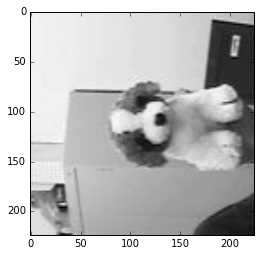

In [6]:
plt.imshow(roi_t0)

In [7]:
roi_t2, _, _= inputProducer.extract_roi(img, gt)

/home/xlws/repos/FCNT_bak/inputproducer.py:85: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  roi = convas[cy-half:cy+half, cx-half:cx+half, :]


In [8]:
roi_t2.sum()

26086479

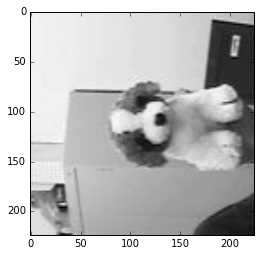

In [9]:
plt.imshow(roi_t2)

In [10]:
roi_t0.sum()

26086479

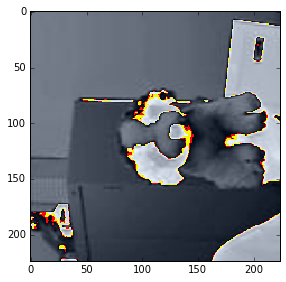

In [11]:
skimage.io.imshow(vgg.img_porcessed.astype(np.uint8))

In [12]:
sess.run(tf.report_uninitialized_variables())

array([], dtype=object)

/home/xlws/anaconda3/lib/python3.5/site-packages/skimage/io/_plugins/matplotlib_plugin.py:77: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "


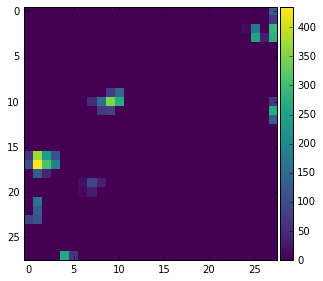

In [13]:
feed_dict = {vgg.imgs: [roi_t0]}
res4, res5 = sess.run([vgg.conv4_3, vgg.conv5_3], feed_dict=feed_dict)
skimage.io.imshow(res4[0,:,:,0])

In [14]:
from scipy.misc import imresize

In [15]:
# Gen anotated mask for target arear
print('Train the local-SelCNN network for %s times.'%FLAGS.iter_step_sel)
t = time.time()
lselCNN = SelCNN('sel_local', vgg.conv4_3, (1,28,28,1))
sgt_M = inputProducer.gen_mask(lselCNN.pre_M_size)
sgt_M = sgt_M[np.newaxis,:,:,np.newaxis]
feed_dict = {vgg.imgs: [roi_t0], lselCNN.gt_M: sgt_M}
loss, pm = train_selCNN(sess, lselCNN, feed_dict)
print('Training the local-SelCNN cost %.2f s'%(time.time() - t))

Train the local-SelCNN network for 600 times.
0.0013186425201 max of mask
(224, 224, 3)
250 max convas


/home/xlws/repos/FCNT_bak/inputproducer.py:85: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  roi = convas[cy-half:cy+half, cx-half:cx+half, :]


[]
Step: 0  , sel_local Learning rate: 1e-06   Loss: 36.53  
Step: 20  , sel_local Learning rate: 9.72655e-07   Loss: 13.24  
Step: 40  , sel_local Learning rate: 9.46058e-07   Loss: 6.24  
Step: 60  , sel_local Learning rate: 9.20188e-07   Loss: 3.81  
Step: 80  , sel_local Learning rate: 8.95025e-07   Loss: 2.39  
Step: 100  , sel_local Learning rate: 8.70551e-07   Loss: 1.92  
Step: 120  , sel_local Learning rate: 8.46745e-07   Loss: 1.67  
Step: 140  , sel_local Learning rate: 8.23591e-07   Loss: 1.26  
Step: 160  , sel_local Learning rate: 8.0107e-07   Loss: 1.02  
Step: 180  , sel_local Learning rate: 7.79165e-07   Loss: 0.78  
Step: 200  , sel_local Learning rate: 7.57858e-07   Loss: 0.70  
Step: 220  , sel_local Learning rate: 7.37135e-07   Loss: 0.61  
Step: 240  , sel_local Learning rate: 7.16978e-07   Loss: 0.53  
Step: 260  , sel_local Learning rate: 6.97372e-07   Loss: 0.46  
Step: 280  , sel_local Learning rate: 6.78302e-07   Loss: 0.43  
Step: 300  , sel_local Learning r

/home/xlws/anaconda3/lib/python3.5/site-packages/skimage/io/_plugins/matplotlib_plugin.py:77: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "


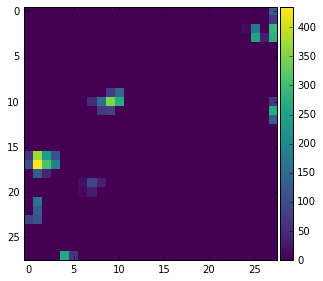

In [16]:
res4, res5 = sess.run([vgg.conv4_3, vgg.conv5_3], feed_dict=feed_dict)
skimage.io.imshow(res4[0,:,:,0])

/home/xlws/anaconda3/lib/python3.5/site-packages/skimage/io/_plugins/matplotlib_plugin.py:77: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "


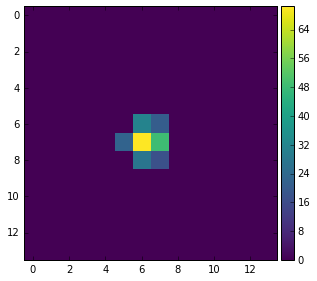

In [17]:
skimage.io.imshow(res5[0,:,:,0])

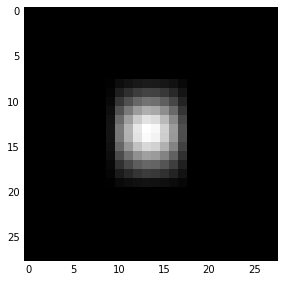

In [18]:

skimage.io.imshow(sgt_M[0,:,:,0])

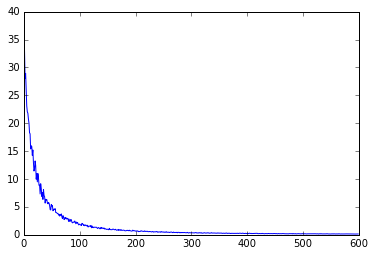

In [19]:
plt.plot(loss)

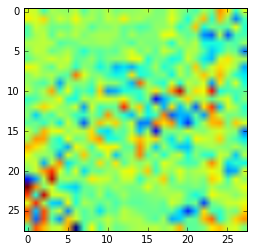

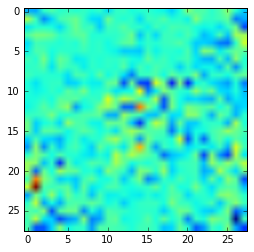

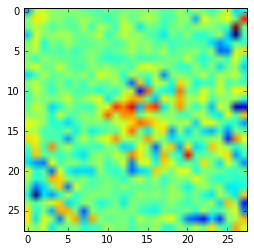

In [20]:
for img in pm:
    plt.figure()
    plt.imshow(img[0,:,:,0])

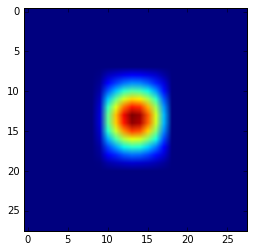

In [21]:
plt.imshow(sgt_M[0,:,:,0])

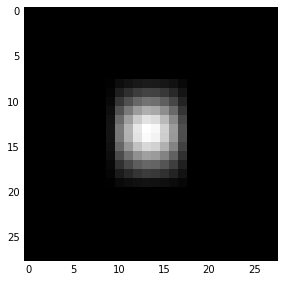

In [22]:
show(sgt_M[0,:,:,0])

In [23]:
tf.reset_default_graph()

In [24]:


print('Train the global-SelCNN network for %s times.'%FLAGS.iter_step_sel)
t = time.time()
gselCNN = SelCNN('sel_global', vgg.conv5_3, (1,14,14,1))
gselCNN.params['lr_initial'] = 1e-10

ggt_M = inputProducer.gen_mask(gselCNN.pre_M_size)
ggt_M = ggt_M[np.newaxis,:,:,np.newaxis]
feed_dict[gselCNN.gt_M] = ggt_M # corrpus the other nets?
loss, pm = train_selCNN(sess, gselCNN, feed_dict)
print('Training the global-SelCNN cost %.2f s'%(time.time() - t))

Train the global-SelCNN network for 600 times.


ValueError: Tensor("sel_global/kernel:0", shape=(3, 3, 512, 1), dtype=float32_ref, device=/device:CPU:0) must be from the same graph as Tensor("dropout/mul:0", shape=(?, 14, 14, 512), dtype=float32).

In [ ]:
plt.plot(loss)

In [ ]:
show(ggt_M[0,:,:,0])

In [ ]:
for img in pm:
    plt.figure()
    plt.imshow(img[0,:,:,0])

In [ ]:
print('Performing local and gloal SelCNN feature map selection.')
t = time.time()
s_sel_maps, s_idx, sgs = lselCNN.sel_feature_maps(sess, vgg.conv4_3, feed_dict,318)
#g_sel_maps, g_idx, sgg = gselCNN.sel_feature_maps(sess, vgg.conv5_3, feed_dict,FLAGS.num_sel)
print('Sel-CNN selection porcesses cost : %.2f s'%(time.time() - t))

In [ ]:
import pandas as p

In [ ]:
s_sel_sum = s_sel_maps.sum(axis=0)


In [ ]:
s_sel_sum = s_sel_sum.sum(axis=-1)

In [ ]:
s_sel_sum.shape

In [ ]:
s_sel_avg = (s_sel_sum / 318)

In [ ]:
show(s_sel_avg)

In [ ]:
original_maps = s_sel_maps

In [ ]:
original_maps.sum()

In [ ]:
res4.sum()

In [ ]:
show((original_maps.sum(axis=0).sum(axis=-1)/318))